# Regrid ERA5 that we have now

In [2]:
import os
import datetime
from pathlib import Path
from collections import defaultdict
import scipy
import random
import numpy as np
import xarray as xr
import pandas as pd
import joblib
import pickle
import xesmf as xe

import seaborn as sns
import cmocean as cm            # really nice colorbars
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import stats

import xesmf 
import PyCO2SYS as pyco2

In [2]:
# We need MSLP (hPa or Atm) at 1x1 resolution
# We need 10m Wind Speed and 10m Wind Speed STD at 1x1 resolution
# We need 10m Wind Speed Squared (Second Moment) at 1x1 resolution

era5 = xr.open_dataset('/data/artemis/observations/ERA5/ERA5_MSLP_WIND_1979-2020.nc')
era5_sst = xr.open_dataset('/data/artemis/observations/ERA5/originals/ERA5_SST_1979-2020.nc')

# si10 = 10m wind speed
# msl is sea level pressure in Pa
# latitude and longitude
# vars(time, expver, latitude, longitude)
# expver = [1, 5] (we are grabbing 1)
# https://confluence.ecmwf.int/pages/viewpage.action?pageId=173385064
# expver 5 is preliminary, instantaneous data for the latest data points
print(era5.expver)

<xarray.DataArray 'expver' (expver: 2)>
array([1, 5], dtype=int32)
Coordinates:
  * expver   (expver) int32 1 5
Attributes:
    long_name:  expver


In [34]:
ws_era5 = era5.si10[:,0,:,:].squeeze()
ws_std = ws_era5.std("time")
ws_squared = ws_era5**2
msl_era5 = era5.msl[:,0,:,:].squeeze()
sst_era5 = era5_sst.sst[:,0,:,:].squeeze()
ws_2nd = ws_squared + ws_std**2

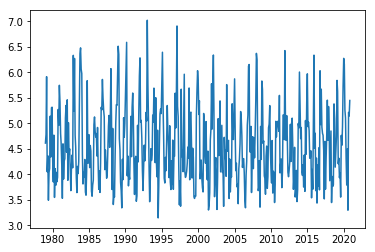

In [5]:
fig = plt.figure()
plt.plot(era5.time,era5.si10[:,0,130,90])

In [5]:
###################################
socat = xr.open_dataset('/data/artemis/observations/SOCAT/originals/SOCATv2020_tracks_gridded_monthly.nc')
ylat = socat.ylat
xlon = socat.xlon

In [36]:
# Interpolate onto SOCAT GRID #####

era_grid = xr.Dataset({'lat':(['lat'],era5.latitude.values),'lon':(['lon'],era5.longitude.values)})
sgrid = xr.Dataset({'lat':(['lat'],ylat.values),'lon':(['lon'],xlon.values)})
ws_in = xr.Dataset({'ws':(['time','lat','lon'],ws_era5),'time':(['time'],era5.time),'lat':(['lat'],era5.latitude.values),'lon':(['lon'],era5.longitude.values)})
ws2_in = xr.Dataset({'ws2':(['time','lat','lon'],ws_squared),'time':(['time'],era5.time),'lat':(['lat'],era5.latitude.values),'lon':(['lon'],era5.longitude.values)})
ws_2nd_in = xr.Dataset({'ws_2nd':(['time','lat','lon'],ws_2nd),'time':(['time'],era5.time),'lat':(['lat'],era5.latitude.values),'lon':(['lon'],era5.longitude.values)})

msl_in = xr.Dataset({'msl':(['time','lat','lon'],msl_era5),'time':(['time'],era5.time),'lat':(['lat'],era5.latitude.values),'lon':(['lon'],era5.longitude.values)})
sst_in = xr.Dataset({'sst':(['time','lat','lon'],sst_era5),'time':(['time'],era5_sst.time),'lat':(['lat'],era5.latitude.values),'lon':(['lon'],era5.longitude.values)})

regridder = xesmf.Regridder(ws_in, sgrid, 'bilinear','periodic')

Overwrite existing file: bilinear_721x1440_180x360_peri.nc 
 You can set reuse_weights=True to save computing time.


In [38]:
regridder = xesmf.Regridder(msl_in, sgrid, 'bilinear','periodic')
msl_out = regridder(msl_in.msl)

Overwrite existing file: bilinear_721x1440_180x360_peri.nc 
 You can set reuse_weights=True to save computing time.


In [37]:
ws_out = regridder(ws_in.ws)


regridder = xesmf.Regridder(ws2_in, sgrid, 'bilinear','periodic')
ws2_out = regridder(ws2_in.ws2)
ws2nd_out = regridder(ws_2nd_in.ws_2nd)

Overwrite existing file: bilinear_721x1440_180x360_peri.nc 
 You can set reuse_weights=True to save computing time.


In [7]:
regridder = xesmf.Regridder(sst_in, sgrid, 'bilinear','periodic')
sst_out = regridder(sst_in.sst)

Overwrite existing file: bilinear_721x1440_180x360_peri.nc 
 You can set reuse_weights=True to save computing time.


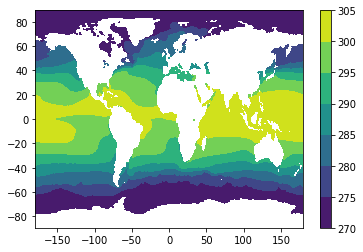

In [8]:
fig = plt.figure()
plt.contourf(sst_out.lon,sst_out.lat,sst_out.mean("time"))
plt.colorbar()

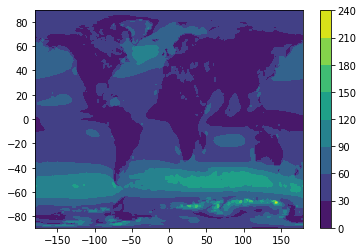

In [9]:
fig = plt.figure()
plt.contourf(ws_out.lon,ws_out.lat,np.mean(ws_out,axis=0)**2)
plt.colorbar()

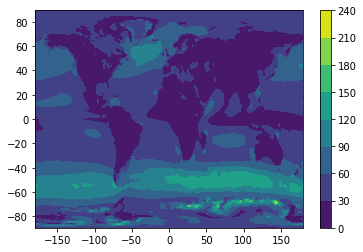

In [39]:
fig = plt.figure()
plt.contourf(ws2_out.lon,ws_out.lat,np.mean(ws2_out,axis=0))
plt.colorbar()

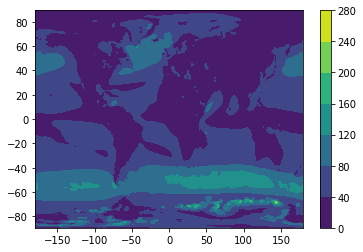

In [40]:
fig = plt.figure()
plt.contourf(ws2_out.lon,ws_out.lat,np.mean(ws2nd_out,axis=0))
plt.colorbar()

In [11]:
##########################
sst_write = xr.Dataset({
                        'sst':(["time","ylat","xlon"],sst_out-273.15)},
                        coords={'time': (['time'],sst_out.time),
                        'ylat': (['ylat'],sst_out.lat),
                        'xlon':(['xlon'],sst_out.lon)})
        
    # Save to netcdf
sst_write['sst'].attrs['units'] = "deg C"
sst_write.to_netcdf('/data/artemis/observations/ERA5/ERA5_SST_1x1_mon_1979-2021.nc')

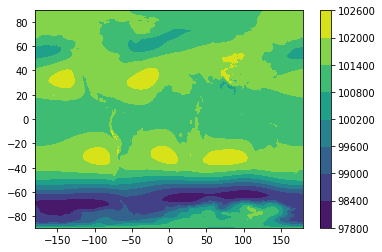

In [12]:
fig = plt.figure()
plt.contourf(msl_out.lon,msl_out.lat,np.mean(msl_out,axis=0))
plt.colorbar()

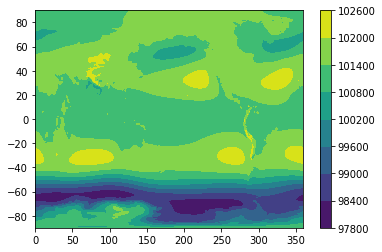

In [20]:
fig = plt.figure()
plt.contourf(era5.longitude,era5.latitude,np.mean(msl_in.msl,axis=0))
plt.colorbar()

In [44]:
# Write to File

msl_write = xr.Dataset({
                        'mslp':(["time","ylat","xlon"],msl_out)},
                        coords={'time': (['time'],msl_out.time),
                        'ylat': (['ylat'],msl_out.lat),
                        'xlon':(['xlon'],msl_out.lon)})
        
    # Save to netcdf
msl_write.to_netcdf('/data/artemis/observations/ERA5/ERA5_MSLP_1x1_mon_1979-2020.nc')

##########################
ws_write = xr.Dataset({
                        'ws10':(["time","ylat","xlon"],ws_out),
                        'ws10_squared':(["time","ylat","xlon"],ws2_out),
                        'ws10_2nd':(["time","ylat","xlon"],ws2nd_out)},
                        coords={'time': (['time'],ws_out.time),
                        'ylat': (['ylat'],ws_out.lat),
                        'xlon':(['xlon'],ws_out.lon)})
        
    # Save to netcdf
ws_write.to_netcdf('/data/artemis/observations/ERA5/ERA5_WS10m_1x1_mon_1979-2020.nc')


# Regrid preliminary 1958-1978 ERA5

In [2]:
era5_wind_prelim = xr.open_dataset('/data/artemis/observations/ERA5/windspeed_1950-1978.nc')
era5_mlsp_prelim = xr.open_dataset('/data/artemis/observations/ERA5/mlsp_1958-1978.nc')
era5_sst_prelim = xr.open_dataset('/data/artemis/observations/ERA5/originals/ERA5_SST_1958-1978.nc')

In [3]:
ws_era5 = era5_wind_prelim.si10.sel(time=slice("01-01-1958","12-31-1978"))
ws_squared = ws_era5**2
ws_2nd = ws_squared + (ws_era5.std("time"))**2
msl_era5 = era5_mlsp_prelim.msl
sst_era5 = era5_sst_prelim.sst

In [4]:
# Interpolate onto SOCAT GRID #####
###################################
socat = xr.open_dataset('/data/artemis/observations/SOCAT/originals/SOCATv2020_tracks_gridded_monthly.nc')
ylat = socat.ylat
xlon = socat.xlon

era_grid = xr.Dataset({'lat':(['lat'],era5_wind_prelim.latitude.values),'lon':(['lon'],era5_wind_prelim.longitude.values)})
sgrid = xr.Dataset({'lat':(['lat'],ylat.values),'lon':(['lon'],xlon.values)})
ws_in = xr.Dataset({'ws':(['time','lat','lon'],ws_era5),'time':(['time'],era5_wind_prelim.time.sel(time=slice("01-01-1958","12-31-1978"))),'lat':(['lat'],era5_wind_prelim.latitude.values),'lon':(['lon'],era5_wind_prelim.longitude.values)})
ws2_in = xr.Dataset({'ws2':(['time','lat','lon'],ws_squared),'time':(['time'],era5_wind_prelim.time.sel(time=slice("01-01-1958","12-31-1978"))),'lat':(['lat'],era5_wind_prelim.latitude.values),'lon':(['lon'],era5_wind_prelim.longitude.values)})
ws2nd_in = xr.Dataset({'ws2nd':(['time','lat','lon'],ws_2nd),'time':(['time'],era5_wind_prelim.time.sel(time=slice("01-01-1958","12-31-1978"))),'lat':(['lat'],era5_wind_prelim.latitude.values),'lon':(['lon'],era5_wind_prelim.longitude.values)})

msl_in = xr.Dataset({'msl':(['time','lat','lon'],msl_era5),'time':(['time'],era5_wind_prelim.time.sel(time=slice("01-01-1958","12-31-1978"))),'lat':(['lat'],era5_wind_prelim.latitude.values),'lon':(['lon'],era5_wind_prelim.longitude.values)})
sst_in = xr.Dataset({'sst':(['time','lat','lon'],sst_era5),'time':(['time'],era5_wind_prelim.time.sel(time=slice("01-01-1958","12-31-1978"))),'lat':(['lat'],era5_wind_prelim.latitude.values),'lon':(['lon'],era5_wind_prelim.longitude.values)})

regridder = xesmf.Regridder(ws_in, sgrid, 'bilinear','periodic')

Overwrite existing file: bilinear_721x1440_180x360_peri.nc 
 You can set reuse_weights=True to save computing time.


In [5]:
regridder = xesmf.Regridder(msl_in, sgrid, 'bilinear','periodic')
msl_out = regridder(msl_in.msl)

Overwrite existing file: bilinear_721x1440_180x360_peri.nc 
 You can set reuse_weights=True to save computing time.


In [6]:
ws_out = regridder(ws_in.ws)
ws2_out = regridder(ws2_in.ws2)
ws2nd_out = regridder(ws2nd_in.ws2nd)

In [7]:
sst_out = regridder(sst_in.sst)

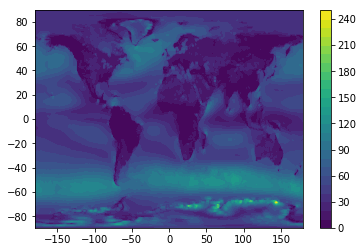

In [29]:
fig = plt.figure()
plt.contourf(ws_out.lon,ws_out.lat,ws2nd_out.mean("time"),levels=np.linspace(0,250,26))
plt.colorbar()

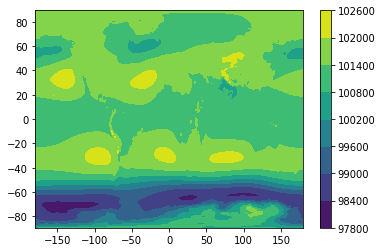

In [21]:
fig = plt.figure()
plt.contourf(msl_out.lon,msl_out.lat,np.mean(msl_out,axis=0))
plt.colorbar()

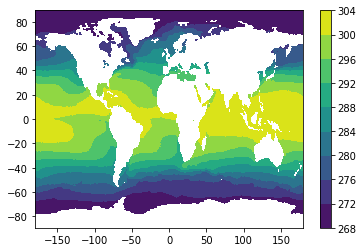

In [40]:
fig = plt.figure()
plt.contourf(sst_out.lon,sst_out.lat,sst_out.mean("time"))
plt.colorbar()

In [8]:
# Write to File

msl_write = xr.Dataset({
                        'mslp':(["time","ylat","xlon"],msl_out)},
                        coords={'time': (['time'],msl_out.time),
                        'ylat': (['ylat'],msl_out.lat),
                        'xlon':(['xlon'],msl_out.lon)})
        
    # Save to netcdf
msl_write.to_netcdf('/data/artemis/observations/ERA5/ERA5_MSLP_1x1_mon_1958-1978.nc')



In [9]:
##########################
ws_write = xr.Dataset({
                        'ws10':(["time","ylat","xlon"],ws_out),
                        'ws10_squared':(["time","ylat","xlon"],ws2_out),
                        'ws10_2nd':(["time","ylat","xlon"],ws2nd_out)},
                        coords={'time': (['time'],ws_out.time),
                        'ylat': (['ylat'],ws_out.lat),
                        'xlon':(['xlon'],ws_out.lon)})
        
    # Save to netcdf
ws_write.to_netcdf('/data/artemis/observations/ERA5/ERA5_WS10m_1x1_mon_1958-1978.nc')

In [10]:
##########################
sst_write = xr.Dataset({
                        'sst':(["time","ylat","xlon"],sst_out-273.15)},
                        coords={'time': (['time'],sst_out.time),
                        'ylat': (['ylat'],sst_out.lat),
                        'xlon':(['xlon'],sst_out.lon)})
        
    # Save to netcdf
sst_write.to_netcdf('/data/artemis/observations/ERA5/ERA5_SST_1x1_mon_1958-1978.nc')

# Make into one long file?

In [56]:
who

LinearRegression	 Path	 all_write	 cm	 datetime	 defaultdict	 era5	 era5_mlsp_prelim	 era5_sst	 
era5_sst_prelim	 era5_wind_prelim	 era_grid	 fig	 joblib	 msl_era5	 msl_in	 msl_later	 msl_out	 
msl_write	 mslp_all	 np	 os	 pd	 pickle	 plt	 pyco2	 random	 
regridder	 scipy	 sgrid	 sns	 socat	 sst_all	 sst_early	 sst_era5	 sst_in	 
sst_later	 sst_out	 sst_write	 stats	 ws2_all	 ws2_in	 ws2_later	 ws2_out	 ws2nd_in	 
ws2nd_out	 ws_2nd	 ws_2nd_in	 ws_all	 ws_era5	 ws_in	 ws_later	 ws_out	 ws_squared	 
ws_std	 ws_write	 xe	 xesmf	 xlon	 xr	 ylat	 


In [11]:
ws_later = xr.open_dataset('/data/artemis/observations/ERA5/ERA5_WS10m_1x1_mon_1979-2020.nc').ws10
ws2_later = xr.open_dataset('/data/artemis/observations/ERA5/ERA5_WS10m_1x1_mon_1979-2020.nc').ws10_squared
ws2nd_later = xr.open_dataset('/data/artemis/observations/ERA5/ERA5_WS10m_1x1_mon_1979-2020.nc').ws10_2nd



msl_later = xr.open_dataset('/data/artemis/observations/ERA5/processed/ERA5_MSLP_1x1_mon_1979-2020.nc').mslp
sst_later = xr.open_dataset('/data/artemis/observations/ERA5/ERA5_SST_1x1_mon_1979-2021.nc').sst

In [12]:
sst_early =  xr.open_dataset('/data/artemis/observations/ERA5/ERA5_SST_1x1_mon_1958-1978.nc').sst


In [13]:
sst_all = xr.concat([sst_early,sst_later],dim='time')

In [14]:
ws_all = xr.concat([ws_write.ws10,ws_later],dim='time')

In [15]:
ws2_all = xr.concat([ws_write.ws10_squared,ws2_later],dim='time')

In [16]:
ws2nd_all = xr.concat([ws_write.ws10_2nd,ws2nd_later],dim='time')

In [17]:
mslp_all = xr.concat([msl_write.mslp,msl_later],dim='time')

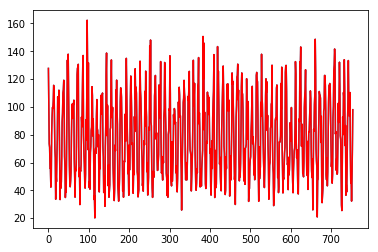

In [31]:
fig = plt.figure()
plt.plot(ws2_all[:,130,130])
plt.plot(ws_all[:,130,130]**2,'red')

In [18]:
# Write to File

all_write = xr.Dataset({
                        'mslp':(["time","ylat","xlon"],mslp_all),
                        'ws10':(['time','ylat','xlon'],ws_all),
                        'ws10_2nd':(['time','ylat','xlon'],ws2nd_all),
                        'ws10_squared':(['time','ylat','xlon'],ws2_all)},
                        coords={'time': (['time'],mslp_all.time),
                        'ylat': (['ylat'],msl_out.lat),
                        'xlon':(['xlon'],msl_out.lon)})
all_write.mslp.attrs["units"] = "Pa"
all_write.ws10.attrs["units"] = 'm/s'
        
    # Save to netcdf
all_write.to_netcdf('/data/artemis/observations/ERA5/processed/ERA5_MSLP_WS10_1x1_mon_1958-2020.nc')

In [8]:
# Write to File

all_sst = xr.Dataset({
                        'sst':(['time','ylat','xlon'],sst_all)},
                        coords={'time': (['time'],sst_all.time),
                        'ylat': (['ylat'],sst_all.ylat),
                        'xlon':(['xlon'],sst_all.xlon)})
all_sst.sst.attrs["units"] = "deg C"
        
    # Save to netcdf
all_sst.to_netcdf('/data/artemis/observations/ERA5/processed/ERA5_SST_1x1_mon_1958-2021.nc')

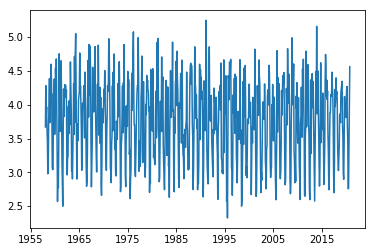

In [36]:
test = xr.open_dataset('/data/artemis/observations/ERA5/processed/ERA5_MSLP_WS10_1x1_mon_1958-2020.nc')
fig = plt.figure()
plt.plot(test.time,test.ws10[:,130,90])

# Get STD of hourly winds for second moment!

In [44]:
# Start with what we have!
for year in range(1996,2020):
    print(year)
    m = 0
    
    date_range_start = f'{year}-01-01T00:00:00.000000000'
    date_range_end = f'{year}-12-31T00:00:00.000000000'
    # create date vector
    dates = pd.date_range(start=date_range_start,end=date_range_end,freq='MS') + np.timedelta64(14, 'D')
    wind_std = np.empty(shape=(12,180,360))
    wind_sqr = np.empty(shape=(12,180,360))
    
    for month in ['01','02','03','04','05','06','07','08','09','10','11','12']:
        
        ex = xr.open_dataset(f"/data/artemis/observations/ERA5/originals/Winds_{year}-{month}.nc")
        tmp_ws = (ex.u10**2 + ex.v10**2)**0.5
        tmp_std = tmp_ws.std("time")
        tmp_sqr = (tmp_ws**2).mean("time")
        
        # Regrid this STD:
        std_in = xr.Dataset({'ws_std':(['lat','lon'],tmp_std),'lat':(['lat'],ex.latitude.values),'lon':(['lon'],ex.longitude.values)})
        sqr_in = xr.Dataset({'ws_sqr':(['lat','lon'],tmp_sqr),'lat':(['lat'],ex.latitude.values),'lon':(['lon'],ex.longitude.values)})
        
        regridder = xesmf.Regridder(std_in, sgrid, 'bilinear','periodic',reuse_weights=True)
        std_out = regridder(std_in.ws_std)
        sqr_out = regridder(sqr_in.ws_sqr)
        
        wind_std[m,:,:] = std_out
        wind_sqr[m,:,:] = sqr_out
        
        del ex,tmp_ws,tmp_std,std_in,std_out,sqr_out,sqr_in,tmp_sqr
        m+=1
###########################################################        
    # Want to write a file for every year:
    wstd = xr.Dataset({
                        'ws_std':(['time','lat','lon'],wind_std),
                        'ws_sqr':(['time','lat','lon'],wind_sqr)},
                        coords={'time': (['time'],dates),
                        'lat': (['lat'],sgrid.lat),
                        'lon':(['lon'],sgrid.lon)})
    
    wstd['ws_std'].attrs['units'] = "(m/s)**0.5"
    wstd['ws_sqr'].attrs['units'] = "m**2 / s**2"
    wstd['ws_std'].attrs['description'] = "Standard deviation of hourly wind speed"
    wstd['ws_sqr'].attrs['description'] = "Mean square of hourly wind speed"
    # Save to netcdf
    wstd.to_netcdf(f'/data/artemis/observations/ERA5/processed/ERA5_WS_STD_1x1_mon_{year}.nc')    
    
    del wstd

1996
Reuse existing file: bilinear_721x1440_180x360_peri.nc
Reuse existing file: bilinear_721x1440_180x360_peri.nc
Reuse existing file: bilinear_721x1440_180x360_peri.nc
Reuse existing file: bilinear_721x1440_180x360_peri.nc
Reuse existing file: bilinear_721x1440_180x360_peri.nc
Reuse existing file: bilinear_721x1440_180x360_peri.nc
Reuse existing file: bilinear_721x1440_180x360_peri.nc
Reuse existing file: bilinear_721x1440_180x360_peri.nc
Reuse existing file: bilinear_721x1440_180x360_peri.nc
Reuse existing file: bilinear_721x1440_180x360_peri.nc
Reuse existing file: bilinear_721x1440_180x360_peri.nc
Reuse existing file: bilinear_721x1440_180x360_peri.nc
1997
Reuse existing file: bilinear_721x1440_180x360_peri.nc
Reuse existing file: bilinear_721x1440_180x360_peri.nc
Reuse existing file: bilinear_721x1440_180x360_peri.nc
Reuse existing file: bilinear_721x1440_180x360_peri.nc
Reuse existing file: bilinear_721x1440_180x360_peri.nc
Reuse existing file: bilinear_721x1440_180x360_peri.nc


In [6]:
date_range_start = f'1958-01-01T00:00:00.000000000'
date_range_end = f'2019-12-31T00:00:00.000000000'
# create date vector
dates_all = pd.date_range(start=date_range_start,end=date_range_end,freq='MS') + np.timedelta64(14, 'D')

# Let's join the files
wind_std = np.empty(shape=((2019-1958+1)*12,180,360))
wind_sqr = np.empty(shape=((2019-1958+1)*12,180,360))

for year in range(1958,2020):
    
    tmp_std = xr.open_dataset(f'/data/artemis/observations/ERA5/processed/ERA5_WS_STD_1x1_mon_{year}.nc').ws_std
    tmp_sqr = xr.open_dataset(f'/data/artemis/observations/ERA5/processed/ERA5_WS_STD_1x1_mon_{year}.nc').ws_sqr
    
    wind_std[(year-1958)*12:(year-1957)*12,:,:] = tmp_std
    wind_sqr[(year-1958)*12:(year-1957)*12,:,:] = tmp_sqr
    
    del tmp_std, tmp_sqr
    
############################################
# write to file
wstd = xr.Dataset({
                        'ws_std':(['time','lat','lon'],wind_std),
                        'ws_sqr':(['time','lat','lon'],wind_sqr)},
                        coords={'time': (['time'],dates_all),
                        'lat': (['lat'],ylat.values),
                        'lon':(['lon'],xlon.values)})
    
wstd['ws_std'].attrs['units'] = "(m/s)**0.5"
wstd['ws_sqr'].attrs['units'] = "(m/s)**2"
wstd['ws_std'].attrs['description'] = "Standard deviation of hourly wind speed"
wstd['ws_sqr'].attrs['description'] = "Mean square of hourly wind speed"
# Save to netcdf
wstd.to_netcdf(f'/data/artemis/observations/ERA5/processed/ERA5_WS_STD_1x1_mon_1958-2019.nc')     